[View in Colaboratory](https://colab.research.google.com/github/ale93111/Unet_dsb2018/blob/master/Unet_weighted_dsb2018.ipynb)

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [2]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pwd

/content


In [0]:
#!fusermount -u drive
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/kaggle/Unet_dsb2018")

In [4]:
#!pip install --upgrade pip
!pip install tqdm
!pip install keras
!pip install imgaug

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 563kB 5.0MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /content/.cache/pip/wheels/31/48/c8/ca3345e8582a078de94243996e148377ef66fdb845557bae0b
Successfully built imgaug


In [5]:
import os

NAME = 'bowl'

# Root directory of the project
ROOT_DIR = os.getcwd()

print(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#Dataset directory
dataset_path = os.path.join(ROOT_DIR, "RCNN_dataset_512_labels")

/content/drive/kaggle/Unet_dsb2018


In [0]:
import numpy as np
from functools import partial, update_wrapper

#partial name fix
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

def pad2n(image,npad=32):
    h, w = image.shape[:2]
    if h % npad > 0:
        max_h = h - (h % npad) + npad
        top_pad = (max_h - h) // 2
        bottom_pad = max_h - h - top_pad
    else:
        top_pad = bottom_pad = 0
    # Width
    if w % npad > 0:
        max_w = w - (w % npad) + npad
        left_pad = (max_w - w) // 2
        right_pad = max_w - w - left_pad
    else:
        left_pad = right_pad = 0

    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='reflect')
    window = (slice(top_pad, h + top_pad),slice(left_pad, w + left_pad))
    
    return image, window
  
def label_to_masks(labels):
    h, w = labels.shape
    n_msk = labels.max()
    masks = np.empty((h,w,n_msk),dtype=np.bool)
    for i in range(n_msk):
        masks[:,:,i] = labels==i+1
    return masks
  
def masks_to_label(msk):
    h, w, _ = msk.shape
    labels = np.zeros((h, w), dtype=np.uint16)
    for index in range(0, msk.shape[-1]):
        labels[msk[:,:,index] > 0] = index + 1
    return labels

In [0]:
import tensorflow as tf
import keras
import keras.backend as K
import keras.layers as KL
import keras.models as KM
import keras.utils as KU
import keras.losses as KLO
from keras.optimizers import Adam, SGD

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0) #AGGIUNTO AXIS=0

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * KLO.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def weighted_loss(y_true,y_pred, weights):
    _epsilon = 10e-8
    y_pred = tf.clip_by_value(y_pred, _epsilon, 1. - _epsilon)
    
    #loss_map = K.binary_crossentropy(y_true, y_pred, from_logits=False) #change if softmax is present or not in the net
    #weighted_loss = loss_map*weights#[:,:,:,np.newaxis]
    #loss=K.mean(weighted_loss)

    return - tf.reduce_sum(y_true * weights *  tf.log(y_pred) +
                          (1 - y_true)  *  tf.log(1 - y_pred),
                          len(y_pred.get_shape()) - 1)

def Unet(img_size=None, GPU_COUNT=1):
  
    inputs         = KL.Input((img_size, img_size, 3))
    weights_tensor = KL.Input((img_size, img_size, 1))
    
    s = KL.Lambda(lambda x: x/128.0 - 1.0)(inputs)

    #TODO: make more general
    c1 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(s)
    n1 = KL.BatchNormalization(axis=3)(c1)
    a1 = KL.Activation("elu")(n1)
    c1 = KL.Dropout(0.2)(a1)
    c1 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
    n1 = KL.BatchNormalization(axis=3)(c1)
    a1 = KL.Activation("elu")(n1)
    p1 = KL.MaxPooling2D((2, 2))(a1)

    c2 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
    n2 = KL.BatchNormalization(axis=3)(c2)
    a2 = KL.Activation("elu")(n2)
    c2 = KL.Dropout(0.2)(a2)
    c2 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
    n2 = KL.BatchNormalization(axis=3)(c2)
    a2 = KL.Activation("elu")(n2)
    p2 = KL.MaxPooling2D((2, 2))(a2)

    c3 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
    n3 = KL.BatchNormalization(axis=3)(c3)
    a3 = KL.Activation("elu")(n3)
    c3 = KL.Dropout(0.3)(a3)
    c3 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
    n3 = KL.BatchNormalization(axis=3)(c3)
    a3 = KL.Activation("elu")(n3)
    p3 = KL.MaxPooling2D((2, 2))(a3)

    c4 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
    n4 = KL.BatchNormalization(axis=3)(c4)
    a4 = KL.Activation("elu")(n4)
    c4 = KL.Dropout(0.4)(a4)
    c4 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
    n4 = KL.BatchNormalization(axis=3)(c4)
    a4 = KL.Activation("elu")(n4)
    p4 = KL.MaxPooling2D(pool_size=(2, 2))(a4)

    c5 = KL.Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same')(p4)
    n5 = KL.BatchNormalization(axis=3)(c5)
    a5 = KL.Activation("elu")(n5)
    c5 = KL.Dropout(0.4)(a5)
    c5 = KL.Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same')(c5)
    n5 = KL.BatchNormalization(axis=3)(c5)
    a5 = KL.Activation("elu")(n5)

    u6 = KL.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(a5)
    u6 = KL.concatenate([u6, a4])
    c6 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(u6)
    n6 = KL.BatchNormalization(axis=3)(c6)
    a6 = KL.Activation("elu")(n6)
    c6 = KL.Dropout(0.4)(a6)
    c6 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
    n6 = KL.BatchNormalization(axis=3)(c6)
    a6 = KL.Activation("elu")(n6)

    u7 = KL.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(a6)
    u7 = KL.concatenate([u7, a3])
    c7 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(u7)
    n7 = KL.BatchNormalization(axis=3)(c7)
    a7 = KL.Activation("elu")(n7)
    c7 = KL.Dropout(0.4)(a7)
    c7 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c7)
    n7 = KL.BatchNormalization(axis=3)(c7)
    a7 = KL.Activation("elu")(n7)

    u8 = KL.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(a7)
    u8 = KL.concatenate([u8, a2])
    c8 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
    n8 = KL.BatchNormalization(axis=3)(c8)
    a8 = KL.Activation("elu")(n8)
    c8 = KL.Dropout(0.2)(a8)
    c8 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c8)
    n8 = KL.BatchNormalization(axis=3)(c8)
    a8 = KL.Activation("elu")(n8)

    u9 = KL.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(a8)
    u9 = KL.concatenate([u9, a1], axis=3)
    c9 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
    n9 = KL.BatchNormalization(axis=3)(c9)
    a9 = KL.Activation("elu")(n9)
    c9 = KL.Dropout(0.2)(a9)
    c9 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c9)
    n9 = KL.BatchNormalization(axis=3)(c9)
    a9 = KL.Activation("elu")(n9)

    outputs = KL.Conv2D(1, (1, 1), activation='sigmoid')(a9)
    
    model = KM.Model(inputs=[inputs,weights_tensor], outputs=[outputs])
    
    weighted_crossentropy = wrapped_partial(weighted_loss, weights=weights_tensor)
    
    model.compile(optimizer=Adam(lr=0.001,clipvalue=5), loss=weighted_crossentropy)

    return model

In [8]:
import cv2
import glob
import skimage.io
import numpy as np
from tqdm import tqdm

#Find paths and load images and labels(=compressed masks)
img_paths = sorted(glob.glob(os.path.join(dataset_path,"*.png")))
msk_paths = sorted(glob.glob(os.path.join(dataset_path,"*.npy")))

img_list = []
lab_list = []
for i,image_path in tqdm(enumerate(img_paths), total=len(img_paths)):
    img_list.append(cv2.imread(img_paths[i]))
    lab_list.append(np.load(msk_paths[i]))

100%|██████████| 979/979 [19:59<00:00,  1.22s/it]


In [9]:
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import distance_transform_edt
from tqdm import tqdm
  
def masks_to_gt(msk):
    h, w, _ = msk.shape
    gt = np.zeros((h, w), dtype=np.bool)
    for index in range(0, msk.shape[-1]):
        gt[msk[:,:,index] > 0] = True
    return gt[:,:,np.newaxis]

def get_weights(masks_in, w0=10, sigma=5):
    """masks_in shape: (w,h,n_masks)"""
    
    masks = np.transpose(masks_in,axes=(2,0,1))
    merged_masks = np.squeeze(masks_to_gt(masks_in))
    
    distances = np.array([distance_transform_edt(m == 0) for m in masks])
    shortest_dist = np.sort(distances, axis=0)
    
    # distance to the border of the nearest cell
    d1 = shortest_dist[0]
    # distance to the border of the second nearest cell
    d2 = shortest_dist[1] if len(shortest_dist) > 1 else np.zeros(d1.shape)

    weights = w0 * np.exp(-(d1 + d2) ** 2 / (2 * sigma ** 2)).astype(np.float32)
    weights = 1 + (merged_masks == 0) * weights
    return weights[..., np.newaxis]

gt_list = []
weight_list = []
for i,label in tqdm(enumerate(lab_list), total=len(lab_list)):
    #Convert to masks
    masks = label_to_masks(label)
    
    #Mask erosion as preprocessing
    for j in range(masks.shape[-1]):
        masks[:,:,j] = binary_erosion(masks[:,:,j].astype(np.uint8), border_value=1, iterations=1)
    masks = masks.astype(np.bool)
    
    #Get ground truths
    gt_list.append(masks_to_gt(masks))
    
    #Compute weights
    weight_list.append(get_weights(masks))

100%|██████████| 979/979 [30:57<00:00,  1.90s/it]


In [0]:
import imgaug 
from imgaug import augmenters as iaa
import random
from random import shuffle
from sklearn.model_selection import train_test_split

def random_crop(image, mask, weights, crop_size = 256):
    h, w = image.shape[:2]
    y = random.randint(0, (h - crop_size))
    x = random.randint(0, (w - crop_size))
    img_crop =   image[y:y + crop_size, x:x + crop_size]
    msk_crop =    mask[y:y + crop_size, x:x + crop_size]
    wgt_crop = weights[y:y + crop_size, x:x + crop_size]
    return img_crop, msk_crop, wgt_crop

def data_generator(img_list, msk_list, wgt_list, batch_size=2, crop_size=256, augmentation=None):
    
    batch_img = np.zeros((batch_size, crop_size, crop_size, 3))
    batch_msk = np.zeros((batch_size, crop_size, crop_size, 1))
    batch_wgt = np.zeros((batch_size, crop_size, crop_size, 1))
    
    image_index = -1
    
    while True:
        for i in range(batch_size):
            image_index = (image_index + 1) % len(img_list)
            
            batch_img[i], batch_msk[i], batch_wgt[i] = random_crop(img_list[image_index],
                                                                   msk_list[image_index],
                                                                   wgt_list[image_index])
        
        if augmentation:
            aug_det = augmentation.to_deterministic()
            batch_img = aug_det.augment_images(batch_img)
            batch_msk = aug_det.augment_images(batch_msk)
            batch_wgt = aug_det.augment_images(batch_wgt)

        yield [batch_img, batch_wgt], batch_msk

def val_data_generator(img_list, msk_list, wgt_list, batch_size=1, augmentation=None):
    
    image_index = -1
  
    while True:
        image_index = (image_index + 1) % len(img_list)
        
        image,   _ = pad2n(img_list[image_index])
        mask,    _ = pad2n(msk_list[image_index])
        weight,  _ = pad2n(wgt_list[image_index])

        yield [image[np.newaxis], weight[np.newaxis]], mask[np.newaxis]

def shuffle_list(*ls):
    l =list(zip(*ls))

    shuffle(l)
    return zip(*l)

#Not used because stage2 images are too big to fit in GPU
def predict_generator(test_list, batch_size=8):

    image_index = -1
    
    while True:
        image_index = (image_index + 1) % len(test_list)
        
        batch_img = np.zeros((batch_size,) + test_list[image_index].shape)
        
        batch_img[0] = test_list[image_index]
        batch_img[1] = np.rot90(test_list[image_index], k=1)
        batch_img[2] = np.rot90(test_list[image_index], k=2)
        batch_img[3] = np.rot90(test_list[image_index], k=3)
        batch_img[4] = np.fliplr(test_list[image_index])
        batch_img[5] = np.flipud(test_list[image_index])
        batch_img[6] = np.rot90(np.fliplr(test_list[image_index]), k=1)
        batch_img[7] = np.rot90(np.flipud(test_list[image_index]), k=1)
        
        yield batch_img
 

In [0]:
batch_size = 16
crop_size = 256
test_split = 0.1
test_size = int(len(img_list)*test_split)
train_size = len(img_list) - test_size

augmentation = iaa.SomeOf((0, 2), [
        iaa.CropAndPad(percent=(-0.15, 0.15), pad_mode="reflect", keep_size=True, sample_independently=False),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)
        ]),
        iaa.OneOf([iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
                                   iaa.WithChannels(0, iaa.Add((0, 100))),
                                   iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
                   iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
                                   iaa.WithChannels(1, iaa.Add((0, 100))),
                                   iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
                   iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
                                   iaa.WithChannels(2, iaa.Add((0, 100))),
                                   iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
                   iaa.WithChannels(0, iaa.Add((0, 100))),
                   iaa.WithChannels(1, iaa.Add((0, 100))),
                   iaa.WithChannels(2, iaa.Add((0, 100)))
        ])
        #imgaug.augmenters.Multiply((0.8, 1.5)),
        #imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
])


#img_train, img_val, gt_train, gt_val = train_test_split(img_list, gt_list, test_size=0.1, random_state=7, shuffle=True)
img_list, gt_list, weight_list = shuffle_list(img_list,gt_list,weight_list)

weight_train = weight_list[:train_size]
img_train    = img_list[:train_size]
gt_train     = gt_list[:train_size]

weight_val = weight_list[-test_size:]
img_val    = img_list[-test_size:]
gt_val     = gt_list[-test_size:]



train_generator = data_generator(img_train,   gt_train, weight_train ,batch_size=batch_size, crop_size=crop_size, augmentation=augmentation)
val_generator   = val_data_generator(img_val, gt_val, weight_val, batch_size=1)

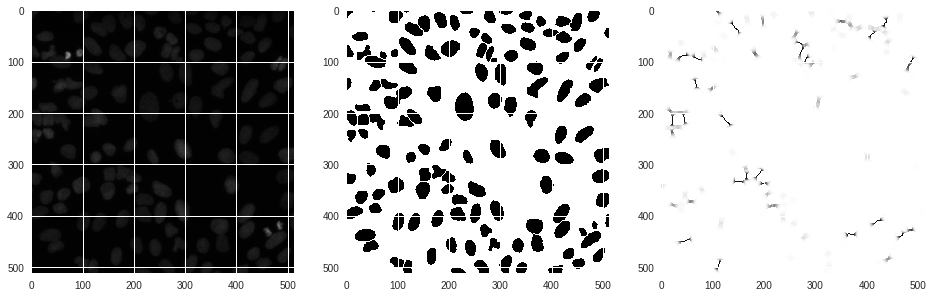

9.899691 1.0 1.1051632


In [24]:
import matplotlib.pyplot as plt
ix_ = np.random.randint(0, len(img_train))

fig = plt.figure(figsize=(16,16))
plt.subplot(1, 3, 1)
plt.imshow(img_train[ix_])
plt.subplot(1, 3, 2)
plt.imshow(gt_train[ix_][...,0])
plt.subplot(1, 3, 3)
plt.imshow(weight_train[ix_][...,0])

plt.show()

print(weight_train[ix_][...,0].max(), weight_train[ix_][...,0].min(), weight_train[ix_][...,0].mean())

In [27]:
import datetime
from keras.optimizers import Adam, SGD

now = datetime.datetime.now()
LOG_DIR = os.path.join(MODEL_DIR, "{}{:%Y%m%dT%H%M}".format(NAME.lower(), now))
checkpoint_path = os.path.join(LOG_DIR, "U_net_{epoch:04d}.h5")

#Model
model = Unet(None)#crop_size)
#model.summary()

#model.compile(optimizer=Adam(lr=0.001), loss=bce_dice_loss, metrics=[mean_iou,KLO.binary_crossentropy])
#model.compile(optimizer=Adam(lr=0.001,clipvalue=5), loss=KLO.binary_crossentropy, metrics=[mean_iou,bce_dice_loss])

# Callbacks
callbacks = [keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=True, write_images=False),
             keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0, save_weights_only=True)
]

model.fit_generator(train_generator, steps_per_epoch=len(img_train)/batch_size, epochs=100,
                    validation_data=val_generator, validation_steps=len(img_val), initial_epoch=0, callbacks=callbacks)

Epoch 1/100
56/55 [==============================] - 72s 1s/step - loss: 0.3926 - val_loss: 0.3087
Epoch 2/100
56/55 [==============================] - 61s 1s/step - loss: 0.2062 - val_loss: 0.5888
Epoch 3/100
56/55 [==============================] - 61s 1s/step - loss: 0.1768 - val_loss: 0.3088
Epoch 4/100
56/55 [==============================] - 61s 1s/step - loss: 0.1427 - val_loss: 1.1184
Epoch 5/100
56/55 [==============================] - 61s 1s/step - loss: 0.1300 - val_loss: 0.1618
Epoch 6/100
37/55 [===================>..........] - ETA: 16s - loss: 0.1201

56/55 [==============================] - 61s 1s/step - loss: 0.1218 - val_loss: 0.2887
Epoch 7/100
56/55 [==============================] - 61s 1s/step - loss: 0.1247 - val_loss: 4.2788
Epoch 8/100
56/55 [==============================] - 61s 1s/step - loss: 0.1244 - val_loss: 0.2331
Epoch 9/100
56/55 [==============================] - 62s 1s/step - loss: 0.1148 - val_loss: 0.1082
Epoch 10/100
56/55 [==============================] - 61s 1s/step - loss: 0.1104 - val_loss: 0.1956
Epoch 11/100
48/55 [=========================>....] - ETA: 6s - loss: 0.1022

56/55 [==============================] - 62s 1s/step - loss: 0.1043 - val_loss: 0.1180
Epoch 12/100
56/55 [==============================] - 62s 1s/step - loss: 0.1017 - val_loss: 0.1538
Epoch 13/100
56/55 [==============================] - 62s 1s/step - loss: 0.1008 - val_loss: 0.1827
Epoch 14/100
56/55 [==============================] - 62s 1s/step - loss: 0.0989 - val_loss: 0.2242
Epoch 15/100
56/55 [==============================] - 61s 1s/step - loss: 0.0947 - val_loss: 0.1199
Epoch 16/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0939

56/55 [==============================] - 62s 1s/step - loss: 0.0949 - val_loss: 0.1840
Epoch 17/100
56/55 [==============================] - 62s 1s/step - loss: 0.0927 - val_loss: 0.1720
Epoch 18/100
56/55 [==============================] - 61s 1s/step - loss: 0.0926 - val_loss: 0.1494
Epoch 19/100
56/55 [==============================] - 62s 1s/step - loss: 0.0855 - val_loss: 0.1219
Epoch 20/100
56/55 [==============================] - 62s 1s/step - loss: 0.0858 - val_loss: 0.0957
Epoch 21/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0854

56/55 [==============================] - 62s 1s/step - loss: 0.0841 - val_loss: 0.0785
Epoch 22/100
56/55 [==============================] - 62s 1s/step - loss: 0.0851 - val_loss: 0.1444
Epoch 23/100
56/55 [==============================] - 62s 1s/step - loss: 0.0823 - val_loss: 0.0910
Epoch 24/100
56/55 [==============================] - 61s 1s/step - loss: 0.0813 - val_loss: 0.0845
Epoch 25/100
56/55 [==============================] - 61s 1s/step - loss: 0.0822 - val_loss: 0.0779
Epoch 26/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0849

56/55 [==============================] - 62s 1s/step - loss: 0.0843 - val_loss: 0.0944
Epoch 27/100
56/55 [==============================] - 61s 1s/step - loss: 0.0784 - val_loss: 0.0800
Epoch 28/100
56/55 [==============================] - 62s 1s/step - loss: 0.0799 - val_loss: 0.0765
Epoch 29/100
56/55 [==============================] - 61s 1s/step - loss: 0.0749 - val_loss: 0.0719
Epoch 30/100
56/55 [==============================] - 61s 1s/step - loss: 0.0778 - val_loss: 0.0893
Epoch 31/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0750

56/55 [==============================] - 62s 1s/step - loss: 0.0759 - val_loss: 0.0738
Epoch 32/100
56/55 [==============================] - 62s 1s/step - loss: 0.0769 - val_loss: 0.0785
Epoch 33/100
56/55 [==============================] - 62s 1s/step - loss: 0.0757 - val_loss: 0.0990
Epoch 34/100
56/55 [==============================] - 62s 1s/step - loss: 0.0749 - val_loss: 0.0786
Epoch 35/100
56/55 [==============================] - 61s 1s/step - loss: 0.0747 - val_loss: 0.0860
Epoch 36/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0713

56/55 [==============================] - 62s 1s/step - loss: 0.0728 - val_loss: 0.0743
Epoch 37/100
56/55 [==============================] - 61s 1s/step - loss: 0.0730 - val_loss: 0.0836
Epoch 38/100
56/55 [==============================] - 61s 1s/step - loss: 0.0787 - val_loss: 0.1888
Epoch 39/100
56/55 [==============================] - 61s 1s/step - loss: 0.0751 - val_loss: 0.0711
Epoch 40/100
56/55 [==============================] - 62s 1s/step - loss: 0.0751 - val_loss: 0.0766
Epoch 41/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0737

56/55 [==============================] - 61s 1s/step - loss: 0.0735 - val_loss: 0.0721
Epoch 42/100
56/55 [==============================] - 62s 1s/step - loss: 0.0711 - val_loss: 0.0781
Epoch 43/100
56/55 [==============================] - 62s 1s/step - loss: 0.0727 - val_loss: 0.1210
Epoch 44/100
56/55 [==============================] - 62s 1s/step - loss: 0.0702 - val_loss: 0.0670
Epoch 45/100
56/55 [==============================] - 62s 1s/step - loss: 0.0703 - val_loss: 0.0700
Epoch 46/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0713

56/55 [==============================] - 61s 1s/step - loss: 0.0700 - val_loss: 0.0719
Epoch 47/100
56/55 [==============================] - 62s 1s/step - loss: 0.0690 - val_loss: 0.0737
Epoch 48/100
56/55 [==============================] - 62s 1s/step - loss: 0.0708 - val_loss: 0.0716
Epoch 49/100
56/55 [==============================] - 62s 1s/step - loss: 0.0701 - val_loss: 0.0769
Epoch 50/100
56/55 [==============================] - 62s 1s/step - loss: 0.0677 - val_loss: 0.0847
Epoch 51/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0704

56/55 [==============================] - 62s 1s/step - loss: 0.0694 - val_loss: 0.0642
Epoch 52/100
56/55 [==============================] - 62s 1s/step - loss: 0.0682 - val_loss: 0.0654
Epoch 53/100
56/55 [==============================] - 62s 1s/step - loss: 0.0668 - val_loss: 0.0668
Epoch 54/100
56/55 [==============================] - 61s 1s/step - loss: 0.0664 - val_loss: 0.0689
Epoch 55/100
56/55 [==============================] - 61s 1s/step - loss: 0.0701 - val_loss: 0.0761
Epoch 56/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0692

56/55 [==============================] - 62s 1s/step - loss: 0.0684 - val_loss: 0.0658
Epoch 57/100
56/55 [==============================] - 61s 1s/step - loss: 0.0680 - val_loss: 0.0695
Epoch 58/100
56/55 [==============================] - 62s 1s/step - loss: 0.0676 - val_loss: 0.0722
Epoch 59/100
56/55 [==============================] - 62s 1s/step - loss: 0.0653 - val_loss: 0.0630
Epoch 60/100
56/55 [==============================] - 62s 1s/step - loss: 0.0642 - val_loss: 0.0630
Epoch 61/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0653

56/55 [==============================] - 61s 1s/step - loss: 0.0643 - val_loss: 0.0668
Epoch 62/100
56/55 [==============================] - 62s 1s/step - loss: 0.0652 - val_loss: 0.0824
Epoch 63/100
56/55 [==============================] - 62s 1s/step - loss: 0.0665 - val_loss: 0.0685
Epoch 64/100
56/55 [==============================] - 62s 1s/step - loss: 0.0683 - val_loss: 0.0671
Epoch 65/100
56/55 [==============================] - 62s 1s/step - loss: 0.0675 - val_loss: 0.0664
Epoch 66/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0638

56/55 [==============================] - 62s 1s/step - loss: 0.0639 - val_loss: 0.0674
Epoch 67/100
56/55 [==============================] - 62s 1s/step - loss: 0.0645 - val_loss: 0.0627
Epoch 68/100
56/55 [==============================] - 61s 1s/step - loss: 0.0641 - val_loss: 0.0631
Epoch 69/100
56/55 [==============================] - 61s 1s/step - loss: 0.0632 - val_loss: 0.0654
Epoch 70/100
56/55 [==============================] - 62s 1s/step - loss: 0.0673 - val_loss: 0.0787
Epoch 71/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0629

56/55 [==============================] - 62s 1s/step - loss: 0.0650 - val_loss: 0.0661
Epoch 72/100
56/55 [==============================] - 62s 1s/step - loss: 0.0641 - val_loss: 0.0662
Epoch 73/100
56/55 [==============================] - 61s 1s/step - loss: 0.0647 - val_loss: 0.0792
Epoch 74/100
56/55 [==============================] - 62s 1s/step - loss: 0.0648 - val_loss: 0.0657
Epoch 75/100
56/55 [==============================] - 62s 1s/step - loss: 0.0632 - val_loss: 0.0658
Epoch 76/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0636

56/55 [==============================] - 62s 1s/step - loss: 0.0646 - val_loss: 0.0632
Epoch 77/100
56/55 [==============================] - 62s 1s/step - loss: 0.0665 - val_loss: 0.0839
Epoch 78/100
56/55 [==============================] - 62s 1s/step - loss: 0.0651 - val_loss: 0.0788
Epoch 79/100
56/55 [==============================] - 62s 1s/step - loss: 0.0635 - val_loss: 0.0822
Epoch 80/100
56/55 [==============================] - 62s 1s/step - loss: 0.0641 - val_loss: 0.0983
Epoch 81/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0643

56/55 [==============================] - 62s 1s/step - loss: 0.0627 - val_loss: 0.0970
Epoch 82/100
56/55 [==============================] - 62s 1s/step - loss: 0.0640 - val_loss: 0.0734
Epoch 83/100
56/55 [==============================] - 62s 1s/step - loss: 0.0637 - val_loss: 0.0710
Epoch 84/100
56/55 [==============================] - 62s 1s/step - loss: 0.0612 - val_loss: 0.0695
Epoch 85/100
56/55 [==============================] - 62s 1s/step - loss: 0.0633 - val_loss: 0.0675
Epoch 86/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0647

56/55 [==============================] - 62s 1s/step - loss: 0.0646 - val_loss: 0.2233
Epoch 87/100
56/55 [==============================] - 62s 1s/step - loss: 0.0659 - val_loss: 0.0721
Epoch 88/100
56/55 [==============================] - 62s 1s/step - loss: 0.0613 - val_loss: 0.0635
Epoch 89/100
56/55 [==============================] - 62s 1s/step - loss: 0.0632 - val_loss: 0.0655
Epoch 90/100
56/55 [==============================] - 62s 1s/step - loss: 0.0635 - val_loss: 0.0615
Epoch 91/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0640

56/55 [==============================] - 62s 1s/step - loss: 0.0649 - val_loss: 0.1094
Epoch 92/100
56/55 [==============================] - 62s 1s/step - loss: 0.0614 - val_loss: 0.0634
Epoch 93/100
56/55 [==============================] - 62s 1s/step - loss: 0.0626 - val_loss: 0.0843
Epoch 94/100
56/55 [==============================] - 62s 1s/step - loss: 0.0617 - val_loss: 0.0599
Epoch 95/100
56/55 [==============================] - 62s 1s/step - loss: 0.0621 - val_loss: 0.0612
Epoch 96/100
48/55 [=========================>....] - ETA: 6s - loss: 0.0593

56/55 [==============================] - 62s 1s/step - loss: 0.0606 - val_loss: 0.0625
Epoch 97/100
56/55 [==============================] - 62s 1s/step - loss: 0.0605 - val_loss: 0.0661
Epoch 98/100
56/55 [==============================] - 62s 1s/step - loss: 0.0615 - val_loss: 0.0622
Epoch 99/100
56/55 [==============================] - 62s 1s/step - loss: 0.0611 - val_loss: 0.0655
Epoch 100/100
56/55 [==============================] - 61s 1s/step - loss: 0.0593 - val_loss: 0.0609


In [0]:
model.fit_generator(train_generator, steps_per_epoch=len(img_train)/batch_size, epochs=600,
                    validation_data=val_generator, validation_steps=len(img_val)/batch_size, initial_epoch=100, callbacks=callbacks)

In [28]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
  
def rleToMask(rleString,height,width):
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

TEST_DIR = "../DSB2018/stage1_test/"

test_ids = next(os.walk(TEST_DIR))[1]

print(test_ids[:3])

images_path = TEST_DIR + "{}/images/{}.png"

test_df = pd.read_csv('stage1_solution.csv')

test_list = []
test_gt = []
for i,id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    image_path = images_path.format(id_,id_)
    image = cv2.imread(image_path)
    
    df_id = test_df.loc[test_df['ImageId'] == id_]#['EncodedPixels']
    
    masks = np.zeros(image.shape[:2]+(len(df_id),), dtype=np.uint8)
    for j in range(len(df_id)):
        rle = df_id.iloc[j]
        masks[:,:,j] = rleToMask(rle['EncodedPixels'], rle['Height'], rle['Width'])
    masks = masks.astype(np.bool)
    
    test_list.append(image)
    test_gt.append(masks)

    
#for i,test_image in tqdm(enumerate(test_list), total=len(test_list)):
#    if not (test_image[:,:,0]==test_image[:,:,1]).all(): #not gray img
#            temp = 255 - (cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)) #convert to gray 1 channel + invert
#            test_list[i] = cv2.cvtColor(temp,cv2.COLOR_GRAY2BGR) #grayscale 3 channels

['1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c', '912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406', 'df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8']


100%|██████████| 65/65 [01:41<00:00,  1.56s/it]


In [0]:
shapes = [img.shape for img in test_list]
a,b=np.unique(shapes, axis=0, return_counts=True)
list(zip(a,b))

[(array([256, 256,   3]), 24),
 (array([260, 347,   3]), 4),
 (array([390, 239,   3]), 1),
 (array([512, 640,   3]), 8),
 (array([512, 680,   3]), 8),
 (array([519, 161,   3]), 2),
 (array([519, 162,   3]), 2),
 (array([519, 253,   3]), 4),
 (array([520, 348,   3]), 4),
 (array([520, 696,   3]), 4),
 (array([524, 348,   3]), 4)]

In [0]:
from skimage.morphology import label
from scipy.ndimage.morphology import binary_dilation

def tta_predict(image, model, cutoff):
    
    tta_n=8
    voting_threshold = 5
    
    batch_tta = []
 
    #Do augmentations
    batch_tta.append(image)
    batch_tta.append(np.rot90(image, k=1))
    batch_tta.append(np.rot90(image, k=2))
    batch_tta.append(np.rot90(image, k=3))
    batch_tta.append(np.fliplr(image))
    batch_tta.append(np.flipud(image))
    batch_tta.append(np.rot90(np.fliplr(image), k=1))
    batch_tta.append(np.rot90(np.flipud(image), k=1))

    #In case image is too big for memory
    res_predict = []
    for tta_img in batch_tta:
        tta_weight = np.ones(tta_img.shape[:2]+(1,),dtype=np.float32)
        res_predict.append(np.squeeze(model.predict([tta_img[np.newaxis], tta_weight[np.newaxis]], verbose=0))>cutoff)
    #print(res_predict[0].shape, res_predict[0].dtype, res_predict[0].max(), res_predict[0].min())
    res_predict = [res_pred.astype(np.bool) for res_pred in res_predict]
    res_predict = [res_pred.astype(np.uint8) for res_pred in res_predict]
    
    #Undo augmentations
    res_predict[0] = res_predict[0]
    res_predict[1] = np.rot90(res_predict[1], k=-1)
    res_predict[2] = np.rot90(res_predict[2], k=-2)
    res_predict[3] = np.rot90(res_predict[3], k=-3)
    res_predict[4] = np.fliplr(res_predict[4])
    res_predict[5] = np.flipud(res_predict[5])
    res_predict[6] = np.rot90(np.fliplr(res_predict[6]), k=1)
    res_predict[7] = np.rot90(np.flipud(res_predict[7]), k=1)
    
    res_predict = np.array(res_predict, dtype=np.uint8)
    #Voting
    tta_sum = np.sum(res_predict,axis=0)
    tta_sum = tta_sum>voting_threshold
    
    return tta_sum

def get_predictions(test_list, model, cutoff=0.5, tta=True, pad=16, dilation=True):
    
    test_predictions = []
    for i,image_test in tqdm(enumerate(test_list), total=len(test_list)):
        image = image_test
        
        #Padding64 to avoid max pool errors in unet
        if pad:
            image, window = pad2n(image, pad)
        
        if tta:
            raw_pred = tta_predict(image, model, cutoff)
        else:
            weight = np.ones(image.shape[:2]+(1,),dtype=np.float32)
            
            image  = image[np.newaxis]
            weight = weight[np.newaxis]

            #Predict
            raw_pred = model.predict([image, weight], verbose=0)

            #Squeeze before remove padding 
            raw_pred = np.squeeze(raw_pred)
        
        raw_pred = raw_pred[window]
        
        
        #Label and thresholding
        pred = label(raw_pred > cutoff)
        
        #Mask conversion
        masks = label_to_masks(pred)
        
        #Mask dilation as post processing
        if dilation:
            for j in range(masks.shape[-1]):
                masks[:,:,j] = binary_dilation(masks[:,:,j].astype(np.uint8), iterations=2)
        masks = masks.astype(np.bool)

        test_predictions.append(masks)
        
    return test_predictions

def find_last(NAME, model_dir):
    """Finds the last checkpoint file of the last trained model in the
    model directory.
    Returns:
        log_dir: The directory where events and weights are saved
        checkpoint_path: the path to the last checkpoint file
    """
    # Get directory names. Each directory corresponds to a model
    dir_names = next(os.walk(model_dir))[1]
    key = NAME.lower()
    dir_names = filter(lambda f: f.startswith(key), dir_names)
    dir_names = sorted(dir_names)
    if not dir_names:
        return None, None
    # Pick last directory
    dir_name = os.path.join(model_dir, dir_names[-1])
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("U_net"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        return dir_name, None
    checkpoint = os.path.join(dir_name, checkpoints[-1])
    return dir_name, checkpoint

In [30]:
#Model
model = Unet(None)

Unet_path = find_last(NAME, MODEL_DIR)[1]
print(Unet_path)

model.load_weights(Unet_path)
#model.load_weights('/content/drive/kaggle/Unet_dsb2018/logs/bowl20180425T2203/U_net_0047.h5')


/content/drive/kaggle/Unet_dsb2018/logs/bowl20180430T2133/U_net_0100.h5


In [31]:
#Evaluation
test_predictions = get_predictions(test_list, model,tta=True, pad=64)

100%|██████████| 65/65 [01:20<00:00,  1.24s/it]


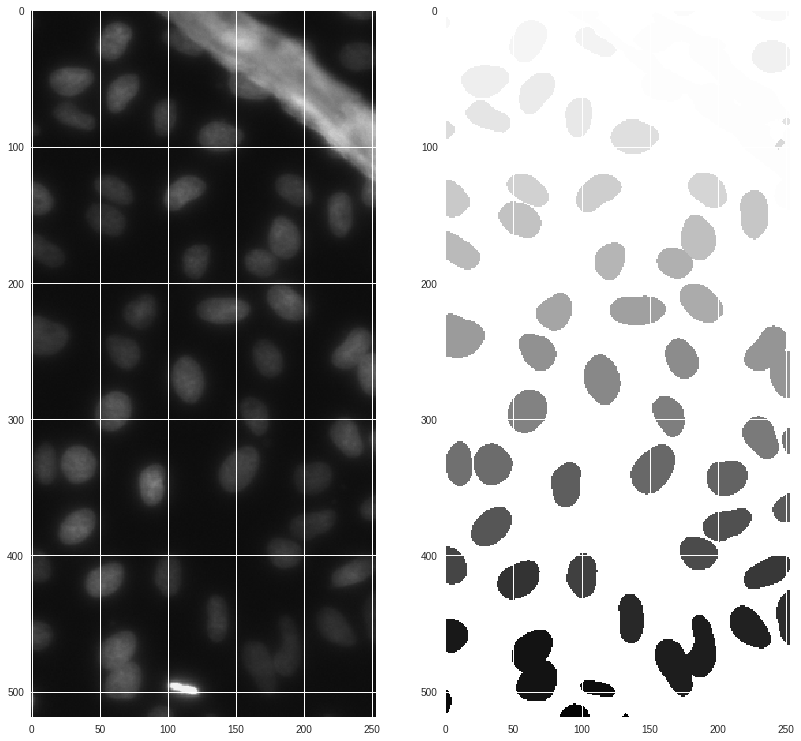

In [48]:
import matplotlib.pyplot as plt
ix_ = np.random.randint(0, len(test_list))

fig = plt.figure(figsize=(21,21))
plt.subplot(1, 3, 1)
plt.imshow(test_list[ix_])
plt.subplot(1, 3, 2)
plt.imshow(masks_to_label(test_predictions[ix_]))

plt.show()

In [0]:
#Rewriting the mIOU function to account for correct number of ground truth mask
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = masks_to_label(y_true_in)
    y_pred = masks_to_label(y_pred_in)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = len(y_true_in)
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
#     return np.array(np.mean(metric), dtype=np.float32)
    return metric


In [34]:
mIOU = np.array(iou_metric_batch(test_gt, test_predictions))
print('The mean IOU is {}'.format(np.mean(mIOU)))

The mean IOU is 0.34429046467230306


(256, 256) bool True False
(256, 256) bool True False


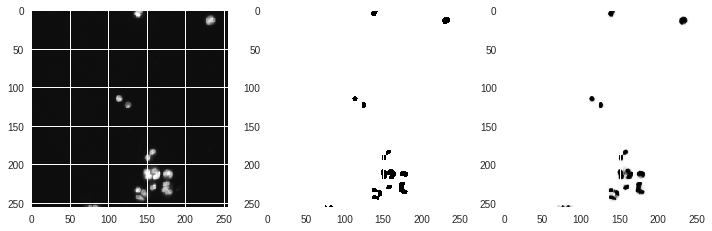

In [0]:
import matplotlib.pyplot as plt
image = test_list[10]

res_tta = tta_predict(image, model,0.5)
print(res_tta.shape, res_tta.dtype, res_tta.max(), res_tta.min())
simage = image[np.newaxis]
#Predict
raw_pred = model.predict(simage, verbose=0) 
raw_pred = np.squeeze(raw_pred)

fig = plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(res_tta)
plt.subplot(133)
plt.imshow(raw_pred)
plt.show()